# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]() & [Vignesh Shridharan](https://github.com/vignesh1987) <br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


### Import necessary modules

In [1]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [2]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [3]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [4]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

In [5]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

# Part 1. Create base grid with H3

hexagons                                           geometry     lon  \
0  87551496dffffff  POLYGON ((25.72919 -13.98478, 25.71906 -13.994... 25.7166   
1  87553202cffffff  POLYGON ((26.43547 -14.15607, 26.42530 -14.166... 26.4228   
2  873469a43ffffff  POLYGON ((28.52398 -13.06274, 28.51388 -13.073... 28.5112   
3  87553652affffff  POLYGON ((27.68832 -14.36206, 27.67810 -14.372... 27.6755   
4  87346d192ffffff  POLYGON ((29.89179 -13.63306, 29.88162 -13.643... 29.8789   

       lat  
0 -13.9803  
1 -14.1515  
2 -13.0582  
3 -14.3574  
4 -13.6284

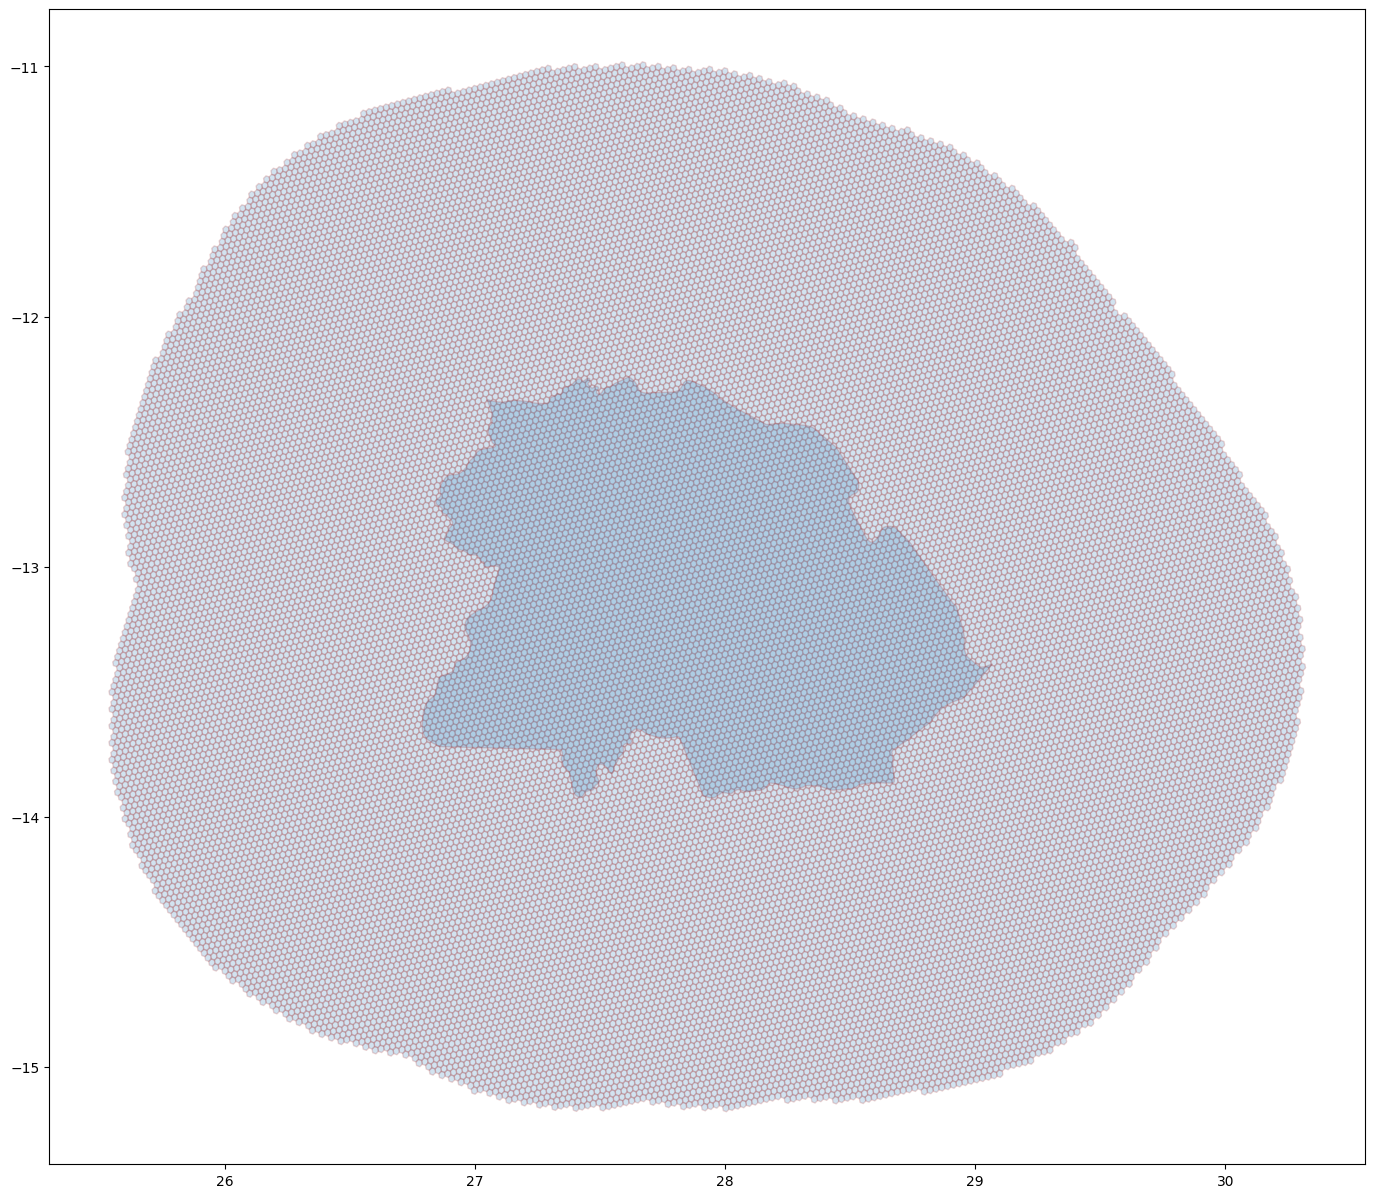

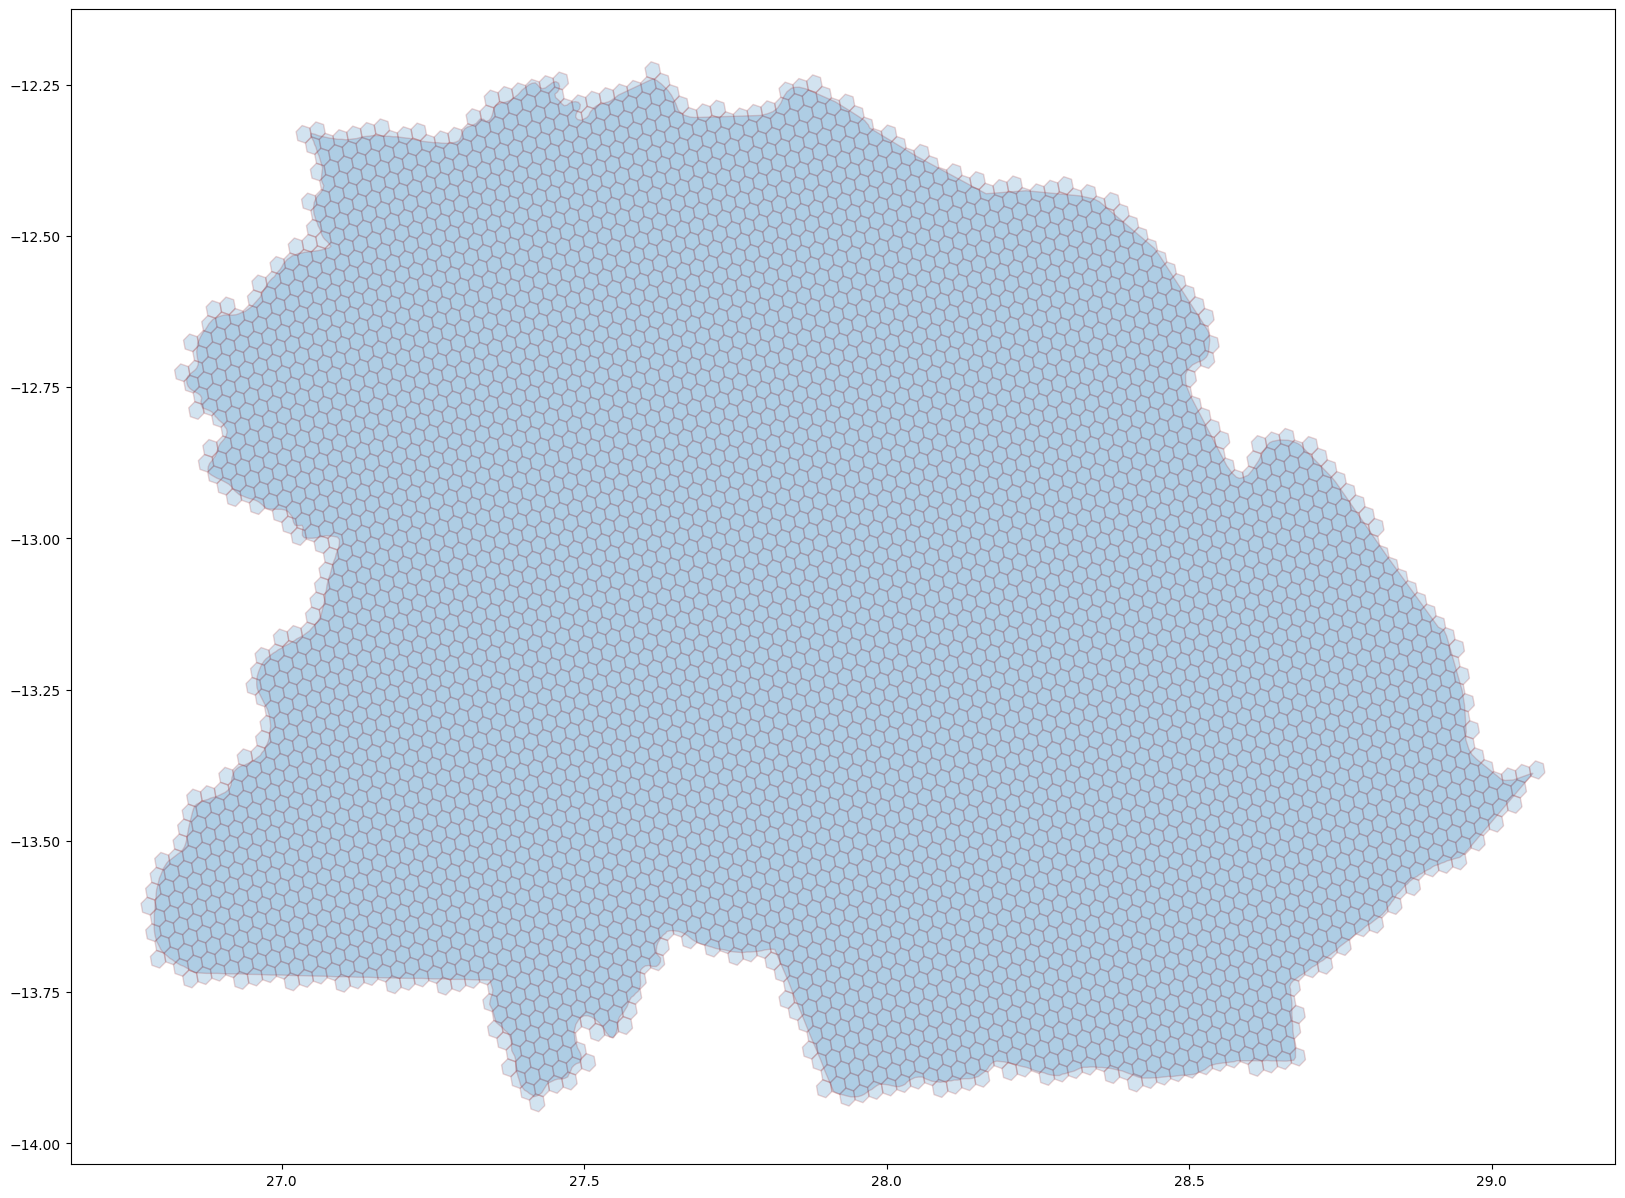

In [6]:
%run BaseGrid.ipynb

In [7]:
# grid = hexagons

# Part 2. Extract GIS-based attributes

## Extract raster values to hexagons

##### Once done with rasters run this cell

In [8]:
# grid = finalizing_rasters(out_path, grid, crs_proj)

Final dataframe

In [9]:
# grid.drop(['index_right'], axis=1, inplace=True)
# grid.head(4)

## Extract information from vector layers

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year X wealth adjustment factor

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

In [10]:
%run Residential/BuildingDemandMethod1.ipynb
total_residentialenergy_assessed = grid["ResEnergy"].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

2023-08-22 09:51:47.444954
2023-08-22 09:52:15.069413
2023-08-22 09:52:33.354468
2023-08-22 09:52:48.349564
2023-08-22 09:52:50.201713
Electricity consumption : 4,022,500,000 MWh
Electricity consumption : 4,022 TWh
total Buildings: 229,956
urban Buildings: 142,855
rural Buildings: 87,101
share Build urban: 62% rural: 38%
nb Of HH per Building urban 3.9 rural 1.0
total ResHH urban 449,077 rural 85,356
totalResHHWithAccessUrb: 339,501
totalResHHWithAccessRur: 23,228
totalResHHWithAccess: 362,729
0.678717038099377
['COPPERBELT']
-0.2856472189317789
residential electricity consumption: 1,819 GWh


In [11]:
# grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*50 if ((row['buildingscount'] > 100))
                                             # else row['buildingscount']*100), axis=1)
# total_servicesenergy_assessed = grid["Commercial"].sum()
# print("services electricity consumption:", f"{total_servicesenergy_assessed/10**6:,.0f}","GWh") # GWh

In [12]:
%run Industry/IndustryDemand.ipynb
print("industry electricity consumption:",f"{total_industryenergy/10**6:,.0f}", "TWh")

total production: 128,215 kt
total industry electricity consumption: 6,360 TWh
energy per tonne of ore: 50 MWh/t
Industry electricity consumption: 1,208 TWh
industry electricity consumption: 1,208 TWh


In [13]:
#Concatenate results
gridRes = gpd.read_file(out_path + "\\" + "res_energy_map.shp")
# gridRes = gridRes.to_crs(crs_proj)
gridInd = gpd.read_file(out_path + "\\" + "ind_energy_map.shp")
# gridInd = gridInd.to_crs(crs_proj)
# init
grid = gridRes.copy()
grid = grid.merge(gridInd, on='id', suffixes=('', '_y'))
# grid = gpd.GeoDataFrame(grid,crs=crs_proj, geometry=grid.geometry)
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
# grid = gpd.pd.concat([gridRes, gridInd])
grid.head(4)

hexagons     lon      lat  index_righ   ADM1_NAME  id  buildingsc  \
0  873469a43ffffff 28.5112 -13.0582      0.0000  COPPERBELT   1          26   
1  875536acdffffff 27.3135 -13.4529      0.0000  COPPERBELT   2           2   
2  87553411bffffff 27.9715 -12.7327      0.0000  COPPERBELT   3          92   
3  875534d8effffff 28.3352 -13.0799      0.0000  COPPERBELT   4          11   

    HREA     rwi  SMODmedian Status_ele Location  ResHHNbWit  ResHHNbW_1  \
0 0.6992 -0.3897         NaN       elec    rural      0.0000     17.8157   
1 0.0028 -0.3000         NaN       elec    rural      0.0000      0.0055   
2 0.5291 -0.3097         NaN       elec    urban    153.0276      0.0000   
3 0.9745  0.5955         NaN       elec    rural      0.0000     10.5046   

   ResHHNbW_2  ResEnergyC    ResEnergy  \
0     17.8157  4,219.3710  52,561.8898   
1      0.0055  3,248.4464       0.0505   
2    153.0276  3,354.0208 271,576.2702   
3     10.5046  6,448.1660  66,007.7784   

                                            geometry     Ore proces  \
0  POLYGON ((28.52398 -13.06274, 28.51388 -13.073...         0.0000   
1  POLYGON ((27.32628 -13.45739, 27.31616 -13.467...         0.0000   
2  POLYGON ((27.98428 -12.73706, 27.97422 -12.747... 1,465,667.0000   
3  POLYGON ((28.34798 -13.08439, 28.33788 -13.094...         0.0000   

        IndEnergy  
0          0.0000  
1          0.0000  
2 72,706,496.3342  
3          0.0000

In [14]:
# type(gridRes)
# gridRes.column

In [15]:
grid["TotalDem"] = grid.apply(lambda row: (row['ResEnergy']  
                                          # + row['Commercial']  
                                           +row["IndEnergy"]
                                          ), axis=1)

In [16]:
total = grid.TotalDem.sum()
print("total electricity consumption:", f"{total/10**6:,.0f}","GWh") # GWh

total electricity consumption: 3,027 GWh


In [17]:
grid.head(3)

hexagons     lon      lat  index_righ   ADM1_NAME  id  buildingsc  \
0  873469a43ffffff 28.5112 -13.0582      0.0000  COPPERBELT   1          26   
1  875536acdffffff 27.3135 -13.4529      0.0000  COPPERBELT   2           2   
2  87553411bffffff 27.9715 -12.7327      0.0000  COPPERBELT   3          92   

    HREA     rwi  SMODmedian  ... Location ResHHNbWit  ResHHNbW_1  ResHHNbW_2  \
0 0.6992 -0.3897         NaN  ...    rural     0.0000     17.8157     17.8157   
1 0.0028 -0.3000         NaN  ...    rural     0.0000      0.0055      0.0055   
2 0.5291 -0.3097         NaN  ...    urban   153.0276      0.0000    153.0276   

   ResEnergyC    ResEnergy                                           geometry  \
0  4,219.3710  52,561.8898  POLYGON ((28.52398 -13.06274, 28.51388 -13.073...   
1  3,248.4464       0.0505  POLYGON ((27.32628 -13.45739, 27.31616 -13.467...   
2  3,354.0208 271,576.2702  POLYGON ((27.98428 -12.73706, 27.97422 -12.747...   

      Ore proces       IndEnergy        TotalDem  
0         0.0000          0.0000     52,561.8898  
1         0.0000          0.0000          0.0505  
2 1,465,667.0000 72,706,496.3342 72,978,072.6044  

[3 rows x 21 columns]

### Export result

In [18]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [19]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + "\\" + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + "\\" + 'total_demand_grid.geojson', driver="GeoJSON")

## Print maps for quick assessment

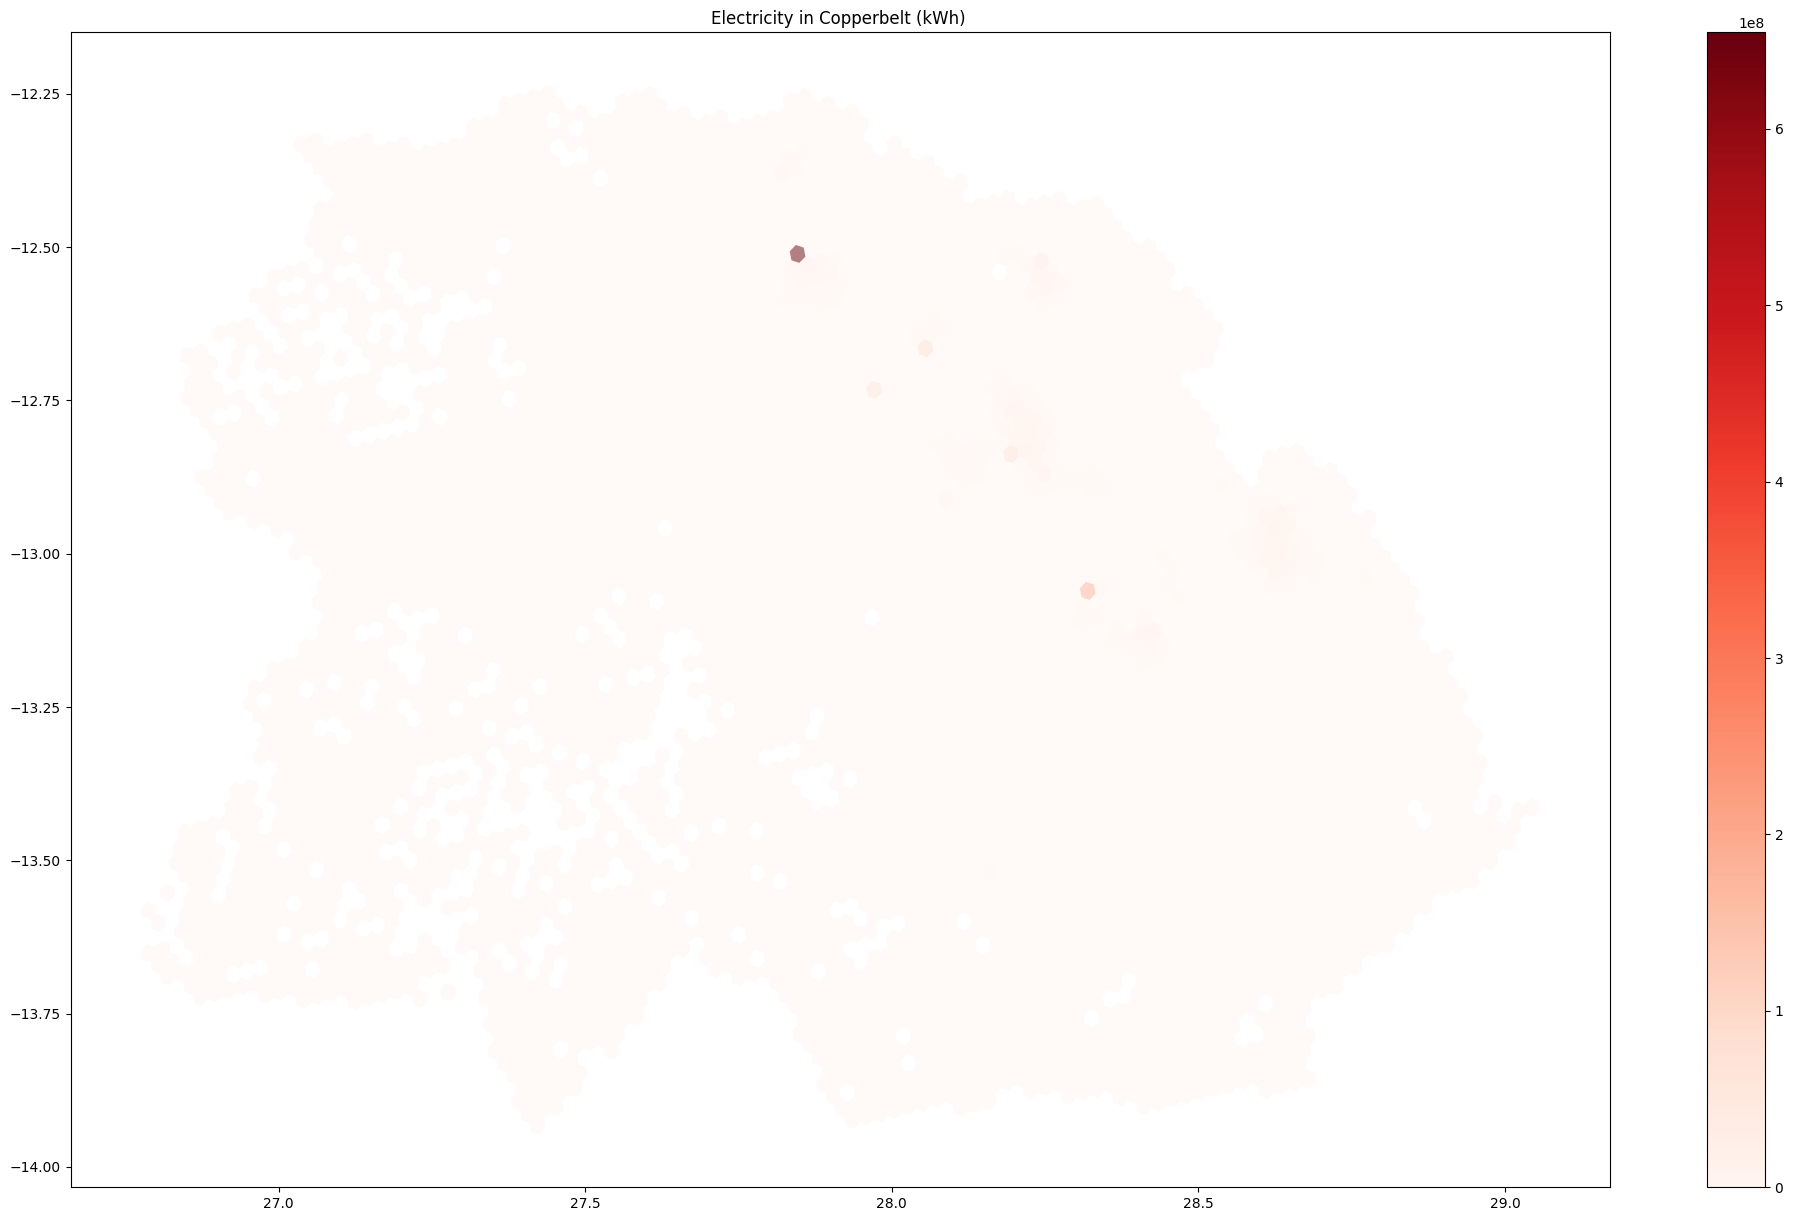

In [20]:
# Plotting for testinf
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot all crops
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} '.format("Copperbelt (kWh)") )

# Save plot as figure 
plt.savefig('sample_priority_map.png', bbox_inches='tight')